# Notes
- The dataset is a custom one -> has a few catgories of landscapes. (Replace with any data in folderwise. One for each class.)
- Misra, D. (2019). Mish: A self regularized non-monotonic neural activation function. arXiv preprint arXiv:1908.08681. [paper](https://arxiv.org/pdf/1908.08681)
- Changing ReLU -> Mish on VGG16 network

In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST, ImageFolder
from torchvision import datasets, transforms
from pytorch_lightning import Trainer
import torchvision.models as models
from collections import Counter
from pytorch_lightning import loggers as pl_loggers
import pickle
import os
os.environ["TORCH_HOME"] = "~/Desktop/Datasets/"

# Create model

In [2]:
class mish(nn.Module):
    def __init__(self):
        super(mish, self).__init__()
    def forward(self, x):
        return x*torch.sigmoid(x)


In [3]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes
        self.accuracy = pl.metrics.Accuracy()
        
        self.conv1 = self.conv_block(2, 3, 64)
        self.conv2 = self.conv_block(2, 64, 128)
        self.conv3 = self.conv_block(3, 128, 256)
        self.conv4 = self.conv_block(3, 256, 512)
        self.conv5 = self.conv_block(3, 512, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classif = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            mish(),
            nn.Dropout(0.25),
            nn.Linear(4096, 4096),
            mish(),
            nn.Dropout(0.25),
            nn.Linear(4096, self.num_classes),
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def conv_block(self, n, inb, out):
        return nn.Sequential(
            nn.Sequential(
                nn.Conv2d(inb, out, kernel_size=3, padding=1, stride=1),
                mish(),
            ),
            *[
                nn.Sequential(
                    nn.Conv2d(out, out, kernel_size=3, padding=1, stride=1),
                    mish(),
                )
                for _ in range(n - 1)
            ],
            nn.MaxPool2d(2, 2)
        )
    def forward(self, x):
        self._initialize_weights()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classif(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('train_acc_step', self.accuracy(preds, y))
        self.log('train_loss', loss)
#         self.log('avg_p_train', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        return loss
    

    def val_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('val_acc_step', self.accuracy(preds, y))
#         self.log('avg_p_val', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        self.log('val_loss', loss)
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('test_acc_step', self.accuracy(preds, y))
#         self.log('avg_p_val', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Load data

In [4]:
class ImDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_classes, data_dir: str = '/home/eragon/Desktop/Datasets/LandscapeSort/'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Augmentation policy
        self.augmentation = transforms.Compose([
              transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
              transforms.RandomRotation(degrees=15),
              transforms.RandomHorizontalFlip(),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        self.transform = transforms.Compose([
              transforms.Resize(size=256),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
        self.num_classes = num_classes

    def setup(self, stage=None):
        # build dataset
        im_dataset = ImageFolder(self.data_dir)
        # split dataset
        self.train, self.val, self.test = random_split(im_dataset, [80, 10, 9])
        self.train.dataset.transform = self.augmentation
        print(dict(Counter(self.train.dataset.targets)))
        print(self.train.dataset.class_to_idx)
        self.val.dataset.transform = self.transform
        self.test.dataset.transform = self.transform
        return self.train.dataset.class_to_idx
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=12)

In [5]:
dm = ImDataModule(batch_size=16,num_classes=4)
class_ids = dm.setup()

{0: 16, 1: 22, 2: 36, 3: 25}
{'Desert': 0, 'Fields': 1, 'Mountain': 2, 'Water': 3}


In [6]:
# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

# Logs

In [7]:
model = LitModel(( 3, 224, 224), 4)

In [8]:
tb_logger = pl_loggers.TensorBoardLogger('./lightning_logs/')

In [9]:
trainer = pl.Trainer(auto_select_gpus=True, gpus=1,
                     precision=16, profiler=False,max_epochs=30,
                    callbacks = [pl.callbacks.ProgressBar()],
                     automatic_optimization=True,logger = tb_logger,enable_pl_optimizer=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eragon/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
Using native 16bit precision.


In [10]:
trainer.fit(model, dm)

/home/eragon/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name     | Type              | Params
-----------------------------------------------
0 | accuracy | Accuracy          | 0     
1 | conv1    | Sequential        | 38.7 K
2 | conv2    | Sequential        | 221 K 
3 | conv3    | Sequential        | 1.5 M 
4 | conv4    | Sequential        | 5.9 M 
5 | conv5    | Sequential        | 7.1 M 
6 | avgpool  | AdaptiveAvgPool2d | 0     
7 | classif  | Sequential        | 119 M 
-----------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params


1

In [11]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc_step': tensor(0.3333, device='cuda:0'),
 'test_loss': tensor(-6.3976e-06, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc_step': 0.3333333432674408, 'test_loss': -6.397565357474377e-06}]

In [14]:
trainer.save_checkpoint('model1.ckpt')

In [15]:
with open("class_ids.pkl","wb+") as f:
    pickle.dump(class_ids, f)

# Inference

In [16]:
from PIL import Image

In [17]:
with open("class_ids.pkl","rb+") as f:
    class_ids = pickle.load(f)

In [18]:
transform = transforms.Compose([
              transforms.Resize(size=256),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

In [19]:
class_ids = {v: k for k, v in class_ids.items()}
class_ids

{0: 'Desert', 1: 'Fields', 2: 'Mountain', 3: 'Water'}

In [20]:
m1 = LitModel.load_from_checkpoint('model1.ckpt')

In [25]:
t_path = "/home/eragon/Desktop/Datasets/LandscapeSort/Mountain/00000025_(7).jpg"

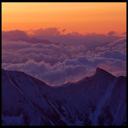

In [26]:
im_sh = Image.open(t_path).convert('RGB');im_sh.resize((128,128))

In [27]:
test = transform(im_sh).unsqueeze(0)

In [28]:
pred = class_ids[int(torch.argmax(m1(test), 1))];pred

'Water'